# Simple data proccessing with even more simple SVM model

I will use Python for data proccessing and Octave for the machine learning model.

In [1]:
# Import python packages
import pandas as pd
import pandas_profiling 

In [3]:
# Read dataset
df_train = pd.read_csv('data/train.csv')
df_test = pd.read_csv('data/test.csv')
# Most of the proccessing will be on the whole dataset, and then we will seperate it back
df_all = pd.concat([df_train, df_test], sort=True).reset_index(drop=True)

In [ ]:
# Generate profile report in html file. 
# Open the html and check the various information about the dataset.
profile = df_train.profile_report(title='Pandas Profiling Report')
profile.to_file(output_file="titanic_data_profiling.html")

## Handle missing data

When we have missing data we have two decisions to make:
1. Should we discard the data
2. How should we fill the data (if not discarded)

### Handle Age column

From the report we can see that Age is missing 177 values (19.9%). 

We will not discard it, because it is valuable information.
We will fill it with median value of the age grouped by Sex and Pclass because they are correlated to Age.

Maybe, it would be ok if we classify the age into groups (0-10, 10-20, ...), but we will check that later.

In [4]:
# Group dataset by Sex and Pclass and fill the empty values with the median by the concrete group.
df_all['Age'] = df_all.groupby(['Sex', 'Pclass'])['Age'].apply(lambda x: x.fillna(x.median()))

### Handle Cabin

Cabin has 687 missing values (77.1%) on the train set. It is large amount of missing values. There is probably a way where we can use this information, but for now we will discard it.

In [5]:
df_all = df_all.drop(columns = ['Cabin'])

### Handle Embarked

Embarked has just two missing values. It has only three distinct values, and most common is S with a large distance, so we will use that value to fill the missing ones.

In [6]:
df_all['Embarked'] = df_all['Embarked'].fillna('S')

### Handle Fare

Fare doesn't have any missing values in the train set, but it has one in the test set. We will set it to the median of the whole dataset.  

In [7]:
df_all['Fare'] = df_all['Fare'].fillna(df_all['Fare'].median())

## Creating new features and removing not important ones

We will have to remove PassengerId feature, because it is not important for our model. But we will do it in the end, because we need this feature for the submission.

The Name feature also seems like not important, bevause every passenger has different name, but if we look closely we can notice that most of the passengers has titles in their names, and this seems like important feature.

In [8]:
# Extract title from the name
df_all['Title'] = df_all['Name'].str.split(', ', expand=True)[1].str.split('.', expand=True)[0]
df_all = df_all.drop(columns = ['Name'])
df_all['Title'].unique()

array(['Mr', 'Mrs', 'Miss', 'Master', 'Don', 'Rev', 'Dr', 'Mme', 'Ms',
       'Major', 'Lady', 'Sir', 'Mlle', 'Col', 'Capt', 'the Countess',
       'Jonkheer', 'Dona'], dtype=object)

We can probably do something more with the titles, but lets leave them like this for now.

We can drop column Name now.

Also, the Ticket column doesn't look important at first. We will get rid of it for the first model.

In [9]:
df_all = df_all.drop(columns = ['Ticket'])

Next thing is to convert categorical data to numbers, so instead ['Mr', 'Mrs', ...] we will have [1, 2, ...].

In [10]:
df_all['Embarked'] = pd.factorize(df_all['Embarked'])[0] + 1
df_all['Sex'] = pd.factorize(df_all['Sex'])[0] + 1
df_all['Title'] = pd.factorize(df_all['Title'])[0] + 1

Now, everything is numerical data, we will save it and we can switch to octave.

In [11]:
df_train = df_all.loc[0 : df_train.shape[0] - 1, :]
survived = df_train.pop('Survived')
df_train.insert(0, 'Survived', survived)
trainPassId = df_train.pop('PassengerId')
df_train.insert(1, 'PassengerId', trainPassId)

df_test = df_all.loc[df_train.shape[0] : df_all.shape[0] - 1, :]
df_test = df_test.drop(columns = ['Survived'])
passId = df_test.pop('PassengerId')
df_test.insert(0, 'PassengerId', passId)

df_train.to_csv('data/train_numeric.csv', header=False, index=False)
df_test.to_csv('data/test_numeric.csv', header=False, index=False)

## Training the model

Now, that we have proccessed data, we can train the model. First, we need to read the data in Octave. Then, we will create validation set from our train set. We will use SVM, and test on the validation set. Then we will make prediction on the test set, and we will see how the model will perform in the test set.

In [12]:
data = csvread('data/train_numeric.csv');
data_test = csvread('data/test_numeric.csv');

%Shuffle data before dividing
data(randperm(size(data, 1)), :);

val_index = size(data); val_index = val_index(1);
val_index = val_index - floor(val_index * 30 / 100);

passId = data(:, 2);
passId_val = passId(val_index+1:end, :);

y = data(:, 1); 
X = data(:, 3:end);
[X mu sigma] = featureNormalize(X);

X_test = data_test(:, 2:end);
[X_test mu_test sigma_test] = featureNormalize(X_test);

X_train = X(1:val_index, :); 
X_val = X(val_index+1:end, :);

y_train = y(1:val_index, :);
y_val = y(val_index+1:end, :);

model = svmtrain(y_train, X_train, '-g 0.3 -c 1');

pred = svmpredict(y_val, X_val, model);

fprintf('\nTraining Set Accuracy: %f\n', mean(double(pred == y_val)) * 100);

*.*.*
optimization finished, #iter = 913
nu = 0.415280
obj = -223.191285, rho = -0.156033
nSV = 324, nBSV = 198
Total nSV = 324
Accuracy = 84.2697% (225/267) (classification)

Training Set Accuracy: 84.269663


We got **84.26%** accuracy on our validation set, which is great, but i don't think it will be that good on the test set. Let's see.

In [13]:
p_test = svmpredict(X_test(:, 1), X_test, model);
test_output = [data_test(:, 1), p_test];
csvwrite('data/output.csv', test_output); % should manually append PassengerId and Survived as name of the columns

Accuracy = 0% (0/418) (classification)


In the test set we got **0.77990** score, so i guess it is pretty descent. If we don't have validation set, the model would perform better on the test set, but this is more accurate verification (We are more confident that the model is not overfitting the test set).

## Debug

So, let's explore our data and model a little more. First, let's plot our learning curves. That way, we will learn if the model has high bias or high variance.

Total nSV = 0
Accuracy = 100% (1/1) (classification)
Accuracy = 64.0449% (171/267) (classification)
*
optimization finished, #iter = 1
nu = 1.000000
obj = -1.008207, rho = 0.000000
nSV = 2, nBSV = 2
Total nSV = 2
Accuracy = 100% (2/2) (classification)
Accuracy = 78.6517% (210/267) (classification)
*
optimization finished, #iter = 2
nu = 0.666667
obj = -1.319435, rho = 0.557909
nSV = 3, nBSV = 1
Total nSV = 3
Accuracy = 100% (3/3) (classification)
Accuracy = 53.5581% (143/267) (classification)
.*.*
optimization finished, #iter = 9
nu = 0.500000
obj = -1.346833, rho = 0.618290
nSV = 4, nBSV = 1
Total nSV = 4
Accuracy = 100% (4/4) (classification)
Accuracy = 52.0599% (139/267) (classification)
.*.*
optimization finished, #iter = 11
nu = 0.734273
obj = -1.835958, rho = 0.307926
nSV = 5, nBSV = 0
Total nSV = 5
Accuracy = 100% (5/5) (classification)
Accuracy = 70.0375% (187/267) (classification)
.*.*
optimization finished, #iter = 13
nu = 0.785061
obj = -2.430920, rho = -0.011593
nSV = 6, nB

DEBUG: FC_WEIGHT didn't match


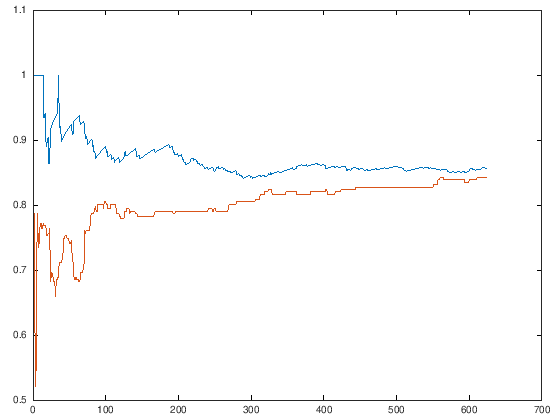

In [14]:
% Plot learning curve
m = size(X_train, 1);
mVal = size(X_val, 1);
for i = 1:m
    model = svmtrain(y_train(1:i), X_train(1:i, :), '-g 0.3 -c 1');
    
    pred_train = svmpredict(y_train(1:i), X_train(1:i, :), model);
    acc_train(i) = mean(double(pred_train == y_train(1:i)));
    
    pred_val = svmpredict(y_val, X_val, model);
    acc_val(i) = mean(double(pred_val == y_val));
end

plot(1:val_index, acc_train, 1:val_index, acc_val)
print -dpng 'learning_curves_1.png';

As we can see, our model has **high bias**. That means, we have to create more features. Let's find the validation examples, where our model made mistakes.

In [15]:
data_val = data(val_index+1:end, :);
missedPassengers = data_val(pred != y_val, :);

sum(missedPassengers(:, 1) == 0) % false positives
sum(missedPassengers(:, 1) == 1) % false negatives

sortrows(missedPassengers, 1)

ans =  10
ans =  32
ans =

 Columns 1 through 6:

     0.00000   655.00000    18.00000     3.00000     6.75000     0.00000
     0.00000   658.00000    32.00000     3.00000    15.50000     1.00000
     0.00000   681.00000    22.00000     3.00000     8.13750     0.00000
     0.00000   695.00000    60.00000     1.00000    26.55000     0.00000
     0.00000   703.00000    18.00000     2.00000    14.45420     1.00000
     0.00000   768.00000    30.50000     3.00000     7.75000     0.00000
     0.00000   773.00000    57.00000     1.00000    10.50000     0.00000
     0.00000   853.00000     9.00000     2.00000    15.24580     1.00000
     0.00000   855.00000    44.00000     1.00000    26.00000     0.00000
     0.00000   889.00000    22.00000     1.00000    23.45000     2.00000
     1.00000   631.00000    80.00000     1.00000    30.00000     0.00000
     1.00000   633.00000    32.00000     2.00000    30.50000     0.00000
     1.00000   644.00000    25.00000     1.00000    56.49580     0.00000
 

In [ ]:
% To be continued, maybe :)